In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:>

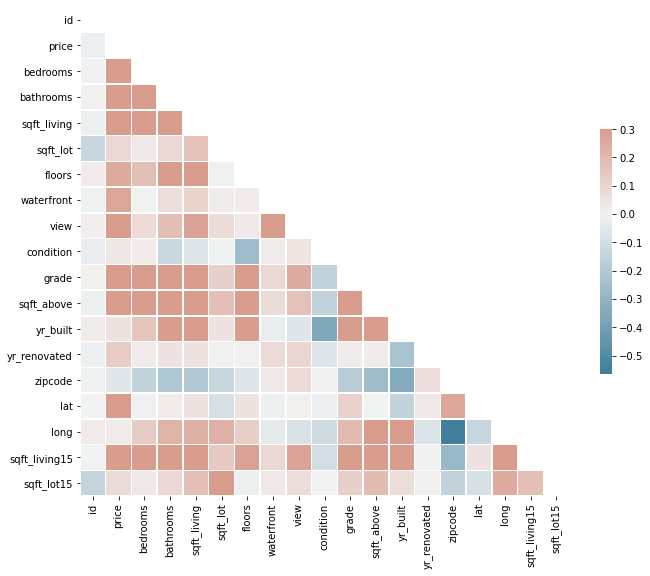

In [34]:
df= pd.read_csv('data/kc_house_data.csv')
corr=df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [35]:
df.corr()


,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
id,1.000000,-0.016772,0.001150,0.005162,-0.012241,-0.131911,0.018608,-0.004176,0.011592,-0.023803,0.008188,-0.010799,0.021617,-0.012010,-0.008211,-0.001798,0.020672,-0.002701,-0.138557
price,-0.016772,1.000000,0.308787,0.525906,0.701917,0.089876,0.256804,0.276295,0.395734,0.036056,0.667951,0.605368,0.053953,0.129599,-0.053402,0.306692,0.022036,0.585241,0.082845
bedrooms,0.001150,0.308787,1.000000,0.514508,0.578212,0.032471,0.177944,-0.002386,0.078523,0.026496,0.356563,0.479386,0.155670,0.018495,-0.154092,-0.009951,0.132054,0.393406,0.030690
bathrooms,0.005162,0.525906,0.514508,1.000000,0.755758,0.088373,0.502582,0.067282,0.186451,-0.126479,0.665838,0.686668,0.507173,0.051050,-0.204786,0.024280,0.224903,0.569884,0.088303
sqft_living,-0.012241,0.701917,0.578212,0.755758,1.000000,0.173453,0.353953,0.110230,0.282532,-0.059445,0.762779,0.876448,0.318152,0.055660,-0.199802,0.052155,0.241214,0.756402,0.184342
sqft_lot,-0.131911,0.089876,0.032471,0.088373,0.173453,1.000000,-0.004814,0.023143,0.075298,-0.008830,0.114731,0.184139,0.052946,0.004513,-0.129586,-0.085514,0.230227,0.144763,0.718204
floors,0.018608,0.256804,0.177944,0.502582,0.353953,-0.004814,1.000000,0.021883,0.028436,-0.264075,0.458794,0.523989,0.489193,0.003535,-0.059541,0.049239,0.125943,0.280102,-0.010722
waterfront,-0.004176,0.276295,-0.002386,0.067282,0.110230,0.023143,0.021883,1.000000,0.406654,0.017642,0.087383,0.075463,-0.026079,0.087244,0.031057,-0.012772,-0.039864,0.088860,0.032002
view,0.011592,0.395734,0.078523,0.186451,0.282532,0.075298,0.028436,0.406654,1.000000,0.045735,0.249727,0.166299,-0.054564,0.100964,0.085277,0.006141,-0.077894,0.279561,0.073332
condition,-0.023803,0.036056,0.026496,-0.126479,-0.059445,-0.008830,-0.264075,0.017642,0.045735,1.000000,-0.146896,-0.158904,-0.361592,-0.061858,0.002888,-0.015102,-0.105877,-0.093072,-0.003126


In [36]:
df.age.hist()
df['old_houses']=df['age']>20
df['new_houses']=df['age']<20
df.corr()

AttributeError: 'DataFrame' object has no attribute 'age'

In [37]:
df=df[['price','sqft_living','bedrooms','bathrooms','floors','grade','condition','yr_built','yr_renovated','waterfront']]
df

,price,sqft_living,bedrooms,bathrooms,floors,grade,condition,yr_built,yr_renovated,waterfront
0,221900.0,1180,3,1.00,1.0,7,3,1955,0.0,NaN
1,538000.0,2570,3,2.25,2.0,7,3,1951,1991.0,0.0
2,180000.0,770,2,1.00,1.0,6,3,1933,NaN,0.0
3,604000.0,1960,4,3.00,1.0,7,5,1965,0.0,0.0
4,510000.0,1680,3,2.00,1.0,8,3,1987,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
21592,360000.0,1530,3,2.50,3.0,8,3,2009,0.0,0.0
21593,400000.0,2310,4,2.50,2.0,8,3,2014,0.0,0.0
21594,402101.0,1020,2,0.75,2.0,7,3,2009,0.0,0.0
21595,400000.0,1600,3,2.50,2.0,8,3,2004,0.0,NaN


In [38]:
df.isnull().sum()

price              0
sqft_living        0
bedrooms           0
bathrooms          0
floors             0
grade              0
condition          0
yr_built           0
yr_renovated    3842
waterfront      2376
dtype: int64

In [39]:
df['waterfront'] = df['waterfront'].fillna(0)

In [40]:
df.isnull().sum()
df['yr_renovated'] = df['yr_renovated'].fillna(0)
df.isnull().sum()

price           0
sqft_living     0
bedrooms        0
bathrooms       0
floors          0
grade           0
condition       0
yr_built        0
yr_renovated    0
waterfront      0
dtype: int64

In [41]:
df.rename(columns={'yr_renovated': 'renovated'}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21597 non-null  float64
 1   sqft_living  21597 non-null  int64  
 2   bedrooms     21597 non-null  int64  
 3   bathrooms    21597 non-null  float64
 4   floors       21597 non-null  float64
 5   grade        21597 non-null  int64  
 6   condition    21597 non-null  int64  
 7   yr_built     21597 non-null  int64  
 8   renovated    21597 non-null  float64
 9   waterfront   21597 non-null  float64
dtypes: float64(5), int64(5)
memory usage: 1.6 MB


In [42]:
df['age'] = 2015 - df.yr_built
df = df.drop(columns=['yr_built'], axis=1)

In [43]:
renovated = df.renovated.values
age = df.age.values
values = np.where(renovated <= 10, 1, 0)
df['renovated'] = np.where(age <= 5, 1, values)

In [44]:
value_counts_bed=df['bedrooms'].value_counts()
to_remove = value_counts_bed[value_counts_bed <=50].index
df = df[~df.bedrooms.isin(to_remove)]

In [45]:
value_counts_bath=df['bathrooms'].value_counts()
to_remove_bath = value_counts_bath[value_counts_bath <=80].index
df = df[~df.bathrooms.isin(to_remove_bath)]

In [46]:
value_counts_floors=df['floors'].value_counts()
to_remove_floor = value_counts_floors[value_counts_floors <=10].index
df = df[~df.floors.isin(to_remove_floor)]

In [47]:
df.head()

,price,sqft_living,bedrooms,bathrooms,floors,grade,condition,renovated,waterfront,age
0,221900.0,1180,3,1.00,1.0,7,3,1,0.0,60
1,538000.0,2570,3,2.25,2.0,7,3,0,0.0,64
2,180000.0,770,2,1.00,1.0,6,3,1,0.0,82
3,604000.0,1960,4,3.00,1.0,7,5,1,0.0,50
4,510000.0,1680,3,2.00,1.0,8,3,1,0.0,28


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21291 entries, 0 to 21595
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        21291 non-null  float64
 1   sqft_living  21291 non-null  int64  
 2   bedrooms     21291 non-null  int64  
 3   bathrooms    21291 non-null  float64
 4   floors       21291 non-null  float64
 5   grade        21291 non-null  int64  
 6   condition    21291 non-null  int64  
 7   renovated    21291 non-null  int32  
 8   waterfront   21291 non-null  float64
 9   age          21291 non-null  int64  
dtypes: float64(4), int32(1), int64(5)
memory usage: 1.7 MB


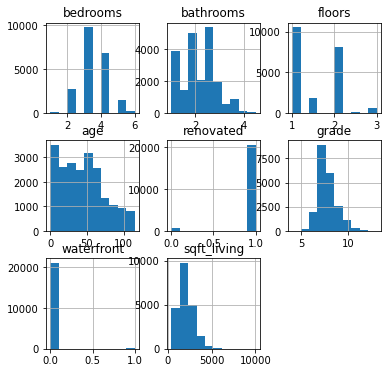

In [49]:
df[['bedrooms', 'bathrooms', 'floors', 'age','renovated','grade','waterfront','sqft_living']].hist(figsize  = [6, 6]); 

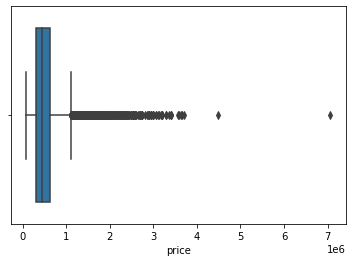

In [50]:
ax = sns.boxplot(x="price", data=df)

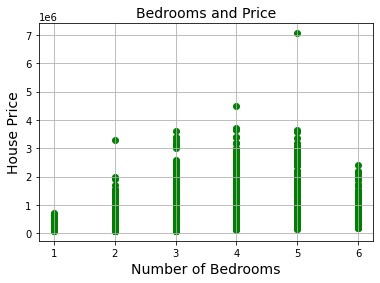

In [51]:
plt.scatter(df['bedrooms'], df['price'], color='green')
plt.title('Bedrooms and Price', fontsize=14)
plt.xlabel('Number of Bedrooms', fontsize=14)
plt.ylabel('House Price', fontsize=14)
plt.grid(True)
plt.show()

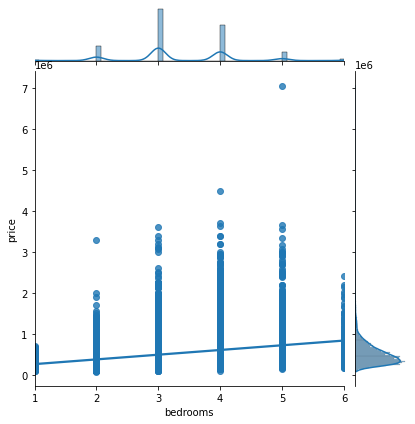

In [52]:
sns.jointplot(data=df, x="bedrooms", y="price", kind="reg")

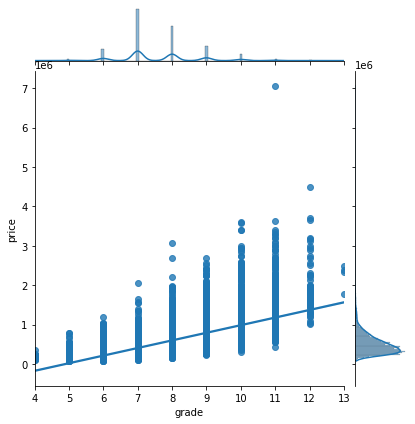

In [53]:
sns.jointplot(data=df, x="grade", y="price", kind="reg")

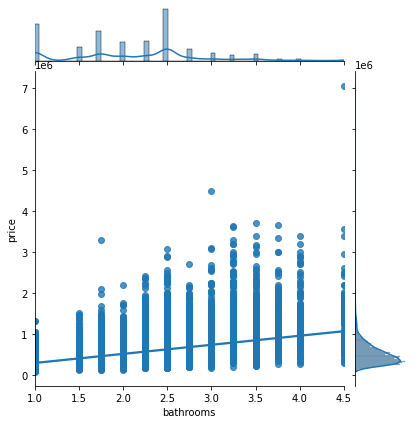

In [54]:
sns.jointplot(data=df, x="bathrooms", y="price", kind="reg")

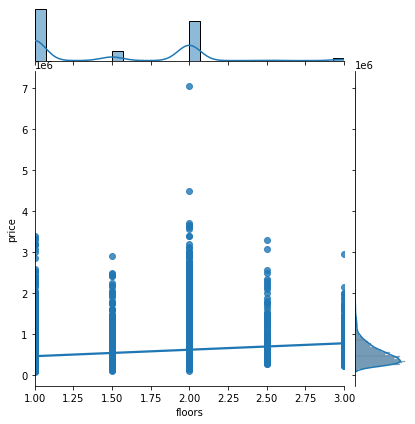

In [55]:
sns.jointplot(data=df, x="floors", y="price", kind="reg")

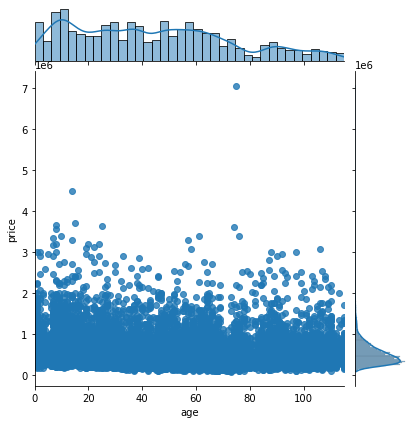

In [56]:
sns.jointplot(data=df, x="age", y="price", kind="reg")

ValueError: Could not interpret value `old_houses` for parameter `x`

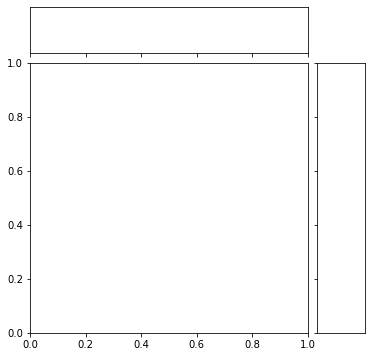

In [58]:
sns.jointplot(data=df, x="old_houses", y="price", kind="reg")

ValueError: Could not interpret value `new_houses` for parameter `x`

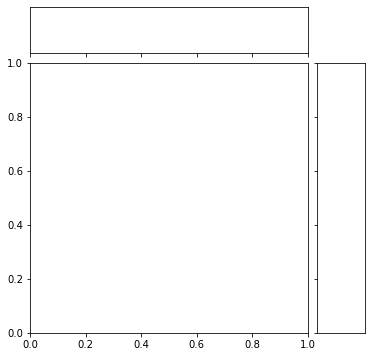

In [59]:
sns.jointplot(data=df, x="new_houses", y="price", kind="reg")

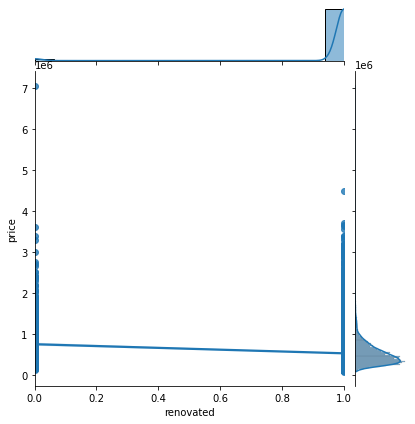

In [60]:
sns.jointplot(data=df, x="renovated", y="price", kind="reg")

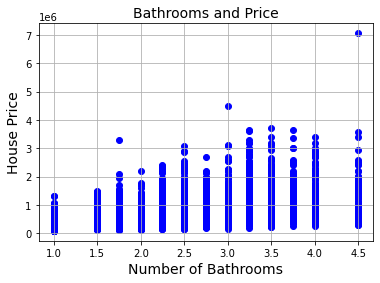

In [61]:
plt.scatter(df['bathrooms'], df['price'], color='blue')
plt.title('Bathrooms and Price', fontsize=14)
plt.xlabel('Number of Bathrooms', fontsize=14)
plt.ylabel('House Price', fontsize=14)
plt.grid(True)
plt.show()

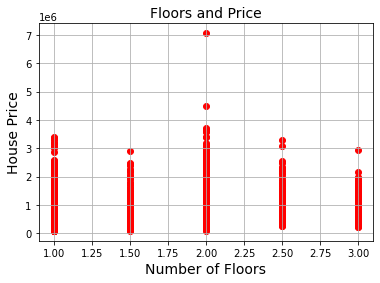

In [62]:
plt.scatter(df['floors'], df['price'], color='red')
plt.title('Floors and Price', fontsize=14)
plt.xlabel('Number of Floors', fontsize=14)
plt.ylabel('House Price', fontsize=14)
plt.grid(True)
plt.show()

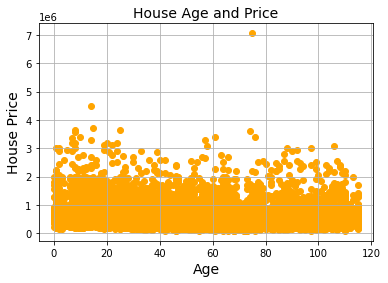

In [63]:
plt.scatter(df['age'], df['price'], color='orange')
plt.title('House Age and Price', fontsize=14)
plt.xlabel('Age', fontsize=14)
plt.ylabel('House Price', fontsize=14)
plt.grid(True)
plt.show()

## Model 1

In [64]:
def tts_model(df):
    y = df['price']
    X = df.drop(columns=['price'], axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)
    
    linreg = LinearRegression()
    model = linreg.fit(X_train, y_train)

    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)

    
    mse_train = mean_squared_error(y_train, train_predictions)
    mse_test = mean_squared_error(y_test, test_predictions)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)

    print('Test RMSE:', np.sqrt(mse_test))
    print('Train RMSE:', np.sqrt(mse_train))
    print('Training Score:', round(train_score, 2))
    print('Test Score:', round(test_score, 2))
    print('Coefficients:', model.coef_)

    X_train = sm.add_constant(X_train)
    smmodel = sm.OLS(y_train, X_train).fit()
    print(smmodel.summary())
    return smmodel

In [65]:
model = tts_model(df)

Test RMSE: 203018.18877140575
Train RMSE: 200466.7079845925
Training Score: 0.63
Test Score: 0.62
Coefficients: [ 1.51789112e+02 -3.77352633e+04  4.06806373e+04  2.30703891e+04
  1.34522857e+05  2.20384566e+04 -3.99873880e+04  7.07510012e+05
  3.55287663e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.633
Method:                 Least Squares   F-statistic:                     3266.
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:04:53   Log-Likelihood:            -2.3210e+05
No. Observations:               17032   AIC:                         4.642e+05
Df Residuals:                   17022   BIC:                         4.643e+05
Df Model:                           9                                         
Covariance Type:            n

<Figure size 864x576 with 0 Axes>

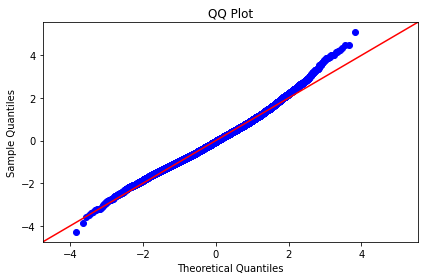

In [92]:
plt.figure(figsize=(12, 8))
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.tight_layout()

In [ ]:
y = df['price']
X = df.drop(columns=['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=123)
    
linreg = LinearRegression()
model = linreg.fit(X_train, y_train)

train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

    
mse_train = mean_squared_error(y_train, train_predictions)
mse_test = mean_squared_error(y_test, test_predictions)
    
train_score = model.score(X_train, y_train)
test_score = model.score(X_test, y_test)

print('Test RMSE:', np.sqrt(mse_test))
print('Train RMSE:', np.sqrt(mse_train))
print('Training Score:', round(train_score, 2))
print('Test Score:', round(test_score, 2))
print('Coefficients:', model.coef_)

    X_train = sm.add_constant(X_train)
    smmodel = sm.OLS(y_train, X_train).fit()
    print(smmodel.summary())
    return smmodel

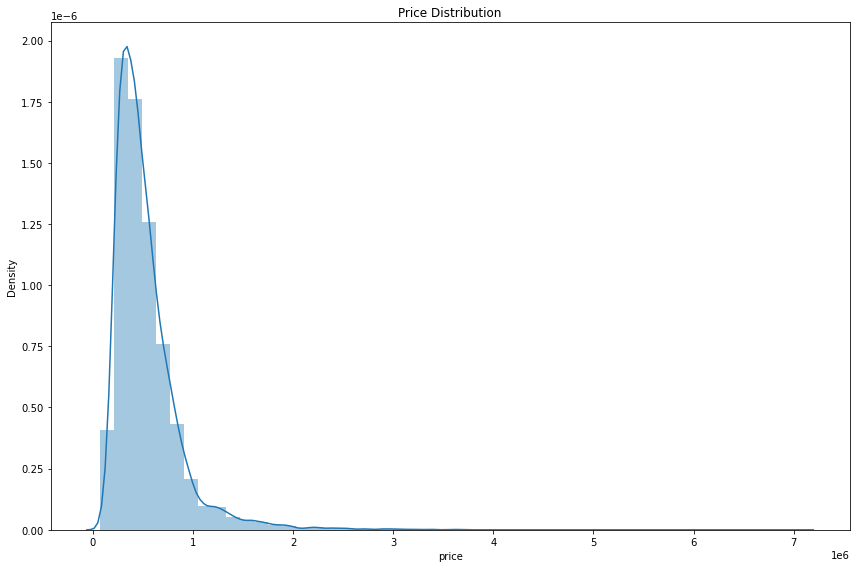

In [68]:
plt.figure(figsize=(12, 8))
sns.distplot(df.price)
plt.title('Price Distribution')
plt.tight_layout()

In [69]:
df = df[df['price'] <= 1000001]

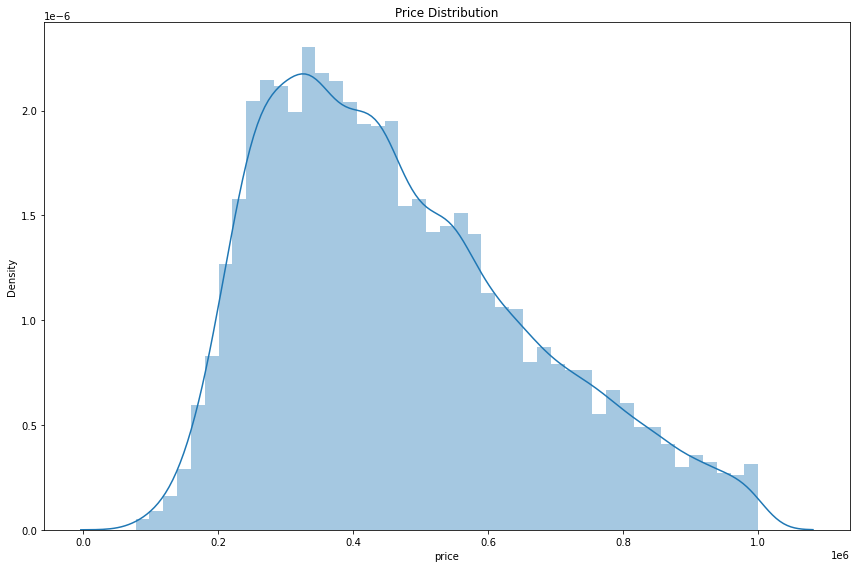

In [70]:
plt.figure(figsize=(12, 8))
sns.distplot(df.price)
plt.title('Price Distribution')
plt.tight_layout()

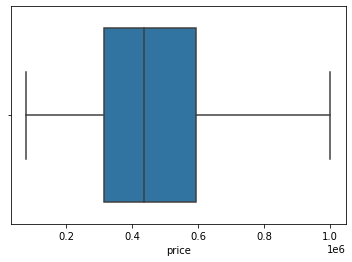

In [71]:
ax = sns.boxplot(x="price", data=df)

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19967 entries, 0 to 21595
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   price        19967 non-null  float64
 1   sqft_living  19967 non-null  int64  
 2   bedrooms     19967 non-null  int64  
 3   bathrooms    19967 non-null  float64
 4   floors       19967 non-null  float64
 5   grade        19967 non-null  int64  
 6   condition    19967 non-null  int64  
 7   renovated    19967 non-null  int32  
 8   waterfront   19967 non-null  float64
 9   age          19967 non-null  int64  
dtypes: float64(4), int32(1), int64(5)
memory usage: 1.6 MB


## Model 2

In [73]:
model = tts_model(df)

Test RMSE: 130131.09725111579
Train RMSE: 132718.3814421091
Training Score: 0.54
Test Score: 0.56
Coefficients: [ 8.69837632e+01 -1.59891916e+04  2.88170493e+04  3.49316297e+04
  9.87595244e+04  1.61903997e+04 -4.63495645e+03  1.79682618e+05
  2.61074995e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     2094.
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:05:00   Log-Likelihood:            -2.1108e+05
No. Observations:               15973   AIC:                         4.222e+05
Df Residuals:                   15963   BIC:                         4.223e+05
Df Model:                           9                                         
Covariance Type:            n

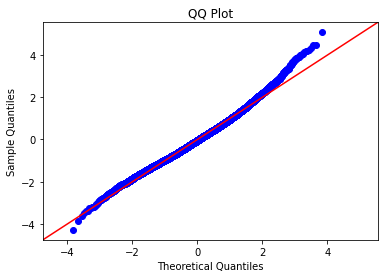

In [74]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

## Multicollinearity Check/Model 3

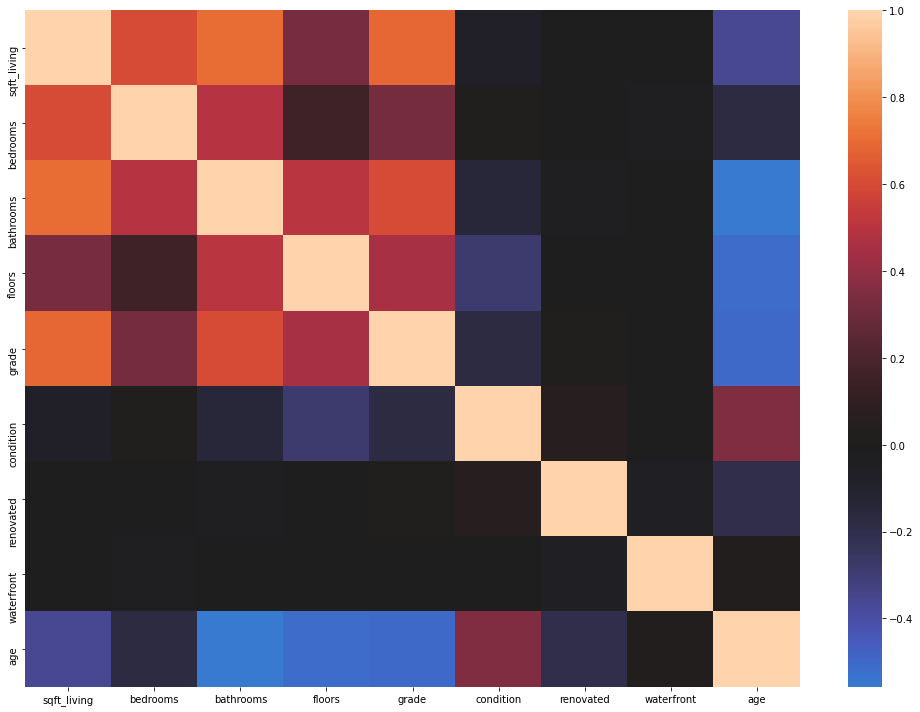

In [75]:
X = df.drop(columns=['price'], axis=1)
plt.figure(figsize=(14, 10))
sns.heatmap(X.corr(), center=0)
plt.tight_layout()
plt.show()

In [76]:
abs(X.corr()) >= .7

,sqft_living,bedrooms,bathrooms,floors,grade,condition,renovated,waterfront,age
sqft_living,True,False,True,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False
bathrooms,True,False,True,False,False,False,False,False,False
floors,False,False,False,True,False,False,False,False,False
grade,False,False,False,False,True,False,False,False,False
condition,False,False,False,False,False,True,False,False,False
renovated,False,False,False,False,False,False,True,False,False
waterfront,False,False,False,False,False,False,False,True,False
age,False,False,False,False,False,False,False,False,True


In [77]:
corr_df = X.corr().abs().stack().reset_index().sort_values(0, ascending=False)

# Zip the variable name columns in a  column named "pairs"
corr_df['pairs'] = list(zip(corr_df.level_0, corr_df.level_1))

# Set index to pairs
corr_df.set_index(['pairs'], inplace = True)

# Drop level columns
corr_df.drop(columns=['level_1', 'level_0'], inplace = True)

# Rename correlation column to cc
corr_df.columns = ['cc']

# Drop duplicates
corr_df.drop_duplicates(inplace=True)

In [78]:
corr_df[(corr_df.cc>.70) & (corr_df.cc <1)]

,cc
pairs,
"(sqft_living, bathrooms)",0.703893


In [79]:
X = sm.add_constant(X)
vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_dict = dict(zip(X.columns, vif))
vif_dict

{'const': 198.68723776917625,
 'sqft_living': 3.2799863817549304,
 'bedrooms': 1.6704918761580536,
 'bathrooms': 2.835805227773111,
 'floors': 1.5955873031688168,
 'grade': 2.378723149847038,
 'condition': 1.2009112732005942,
 'renovated': 1.0946441510732874,
 'waterfront': 1.0046614168041497,
 'age': 2.018735346549424}

In [80]:
tts_model(df)

Test RMSE: 130131.09725111579
Train RMSE: 132718.3814421091
Training Score: 0.54
Test Score: 0.56
Coefficients: [ 8.69837632e+01 -1.59891916e+04  2.88170493e+04  3.49316297e+04
  9.87595244e+04  1.61903997e+04 -4.63495645e+03  1.79682618e+05
  2.61074995e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     2094.
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:05:10   Log-Likelihood:            -2.1108e+05
No. Observations:               15973   AIC:                         4.222e+05
Df Residuals:                   15963   BIC:                         4.223e+05
Df Model:                           9                                         
Covariance Type:            n

In [81]:
df = df.drop(columns=['renovated'], axis=1)

In [82]:
tts_model(df)

Test RMSE: 130114.50040703971
Train RMSE: 132720.5553525063
Training Score: 0.54
Test Score: 0.56
Coefficients: [ 8.69860448e+01 -1.60315850e+04  2.90620464e+04  3.50164458e+04
  9.87731133e+04  1.60109515e+04  1.80496089e+05  2.62185550e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     2355.
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:05:11   Log-Likelihood:            -2.1108e+05
No. Observations:               15973   AIC:                         4.222e+05
Df Residuals:                   15964   BIC:                         4.223e+05
Df Model:                           8                                         
Covariance Type:            nonrobust         

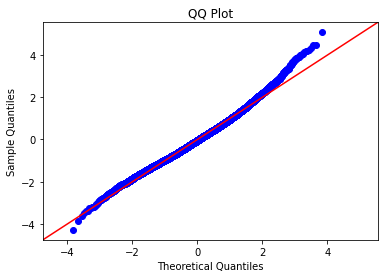

In [83]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

## Model 4

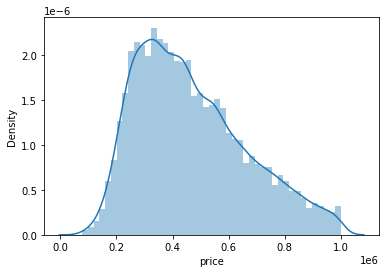

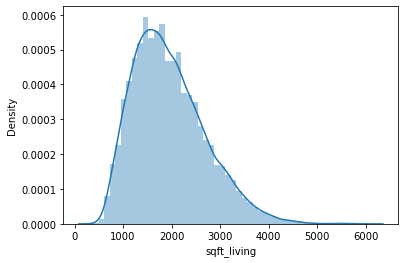

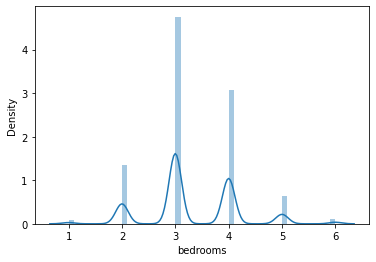

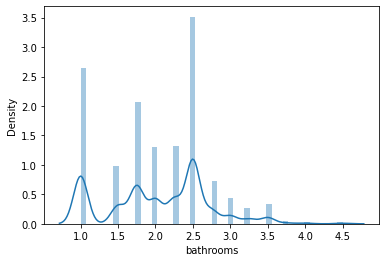

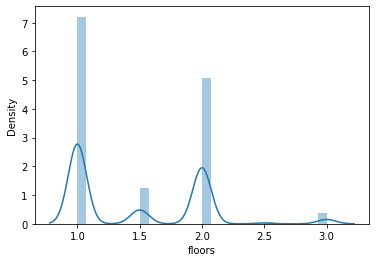

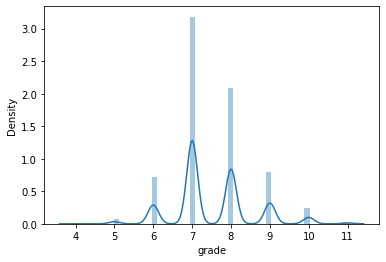

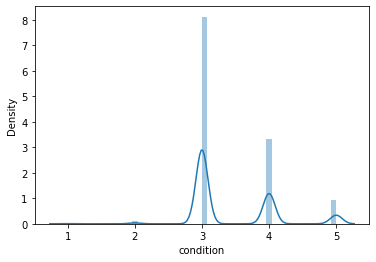

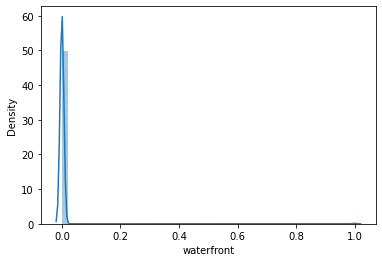

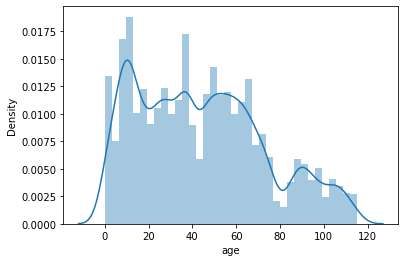

In [84]:
#View distribution plots for all columns
for col in df.columns:
    plt.subplots(1, 1)
    sns.distplot(df[col])

In [85]:
df = df[df['sqft_living'] < 5000]
df = df[df['bathrooms'] < 4.0]
df = df[df['floors'] < 3.5]

In [86]:
tts_model(df)

Test RMSE: 131811.02693317196
Train RMSE: 131943.3903663805
Training Score: 0.54
Test Score: 0.55
Coefficients: [ 8.83509246e+01 -1.61215851e+04  2.97785812e+04  3.68698103e+04
  9.79497454e+04  1.67996148e+04  1.63411119e+05  2.61699609e+03]
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.540
Method:                 Least Squares   F-statistic:                     2333.
Date:                Thu, 08 Jul 2021   Prob (F-statistic):               0.00
Time:                        15:05:17   Log-Likelihood:            -2.0985e+05
No. Observations:               15887   AIC:                         4.197e+05
Df Residuals:                   15878   BIC:                         4.198e+05
Df Model:                           8                                         
Covariance Type:            nonrobust         

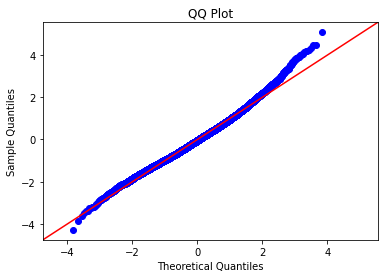

In [87]:
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)
plt.title('QQ Plot')
plt.show()

## Model 5

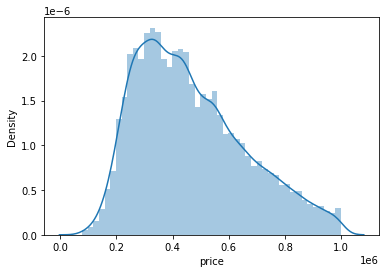

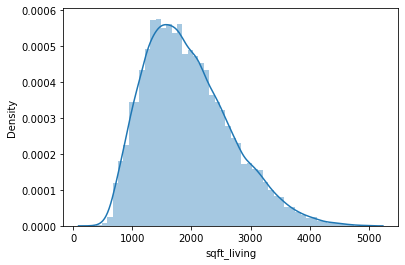

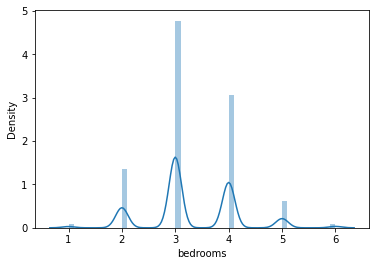

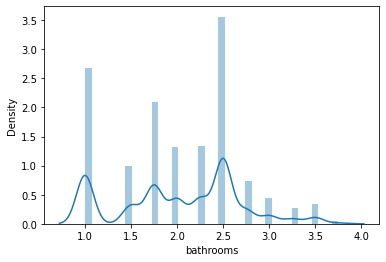

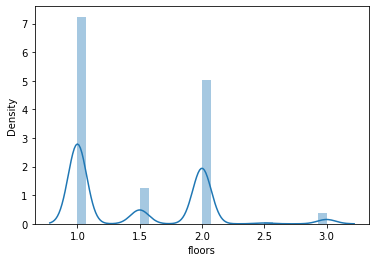

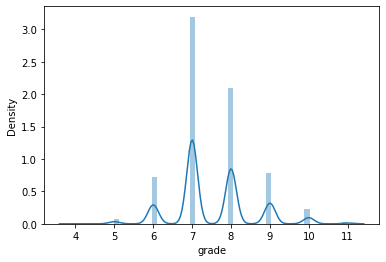

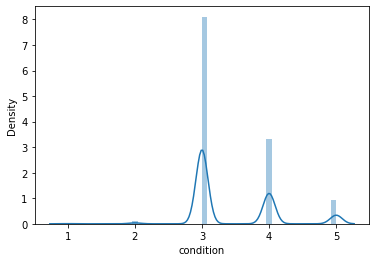

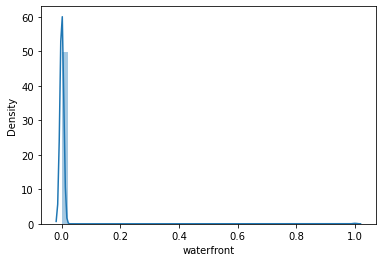

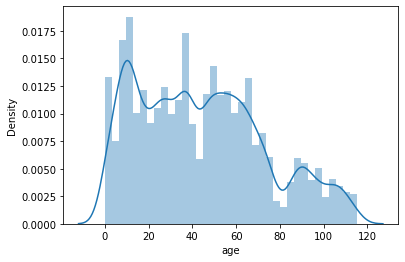

In [88]:
#View distribution plots for all columns
for col in df.columns:
    plt.subplots(1, 1)
    sns.distplot(df[col])

In [89]:
from itertools import combinations